In [30]:
import os
import warnings

os.makedirs("../output", exist_ok=True)
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd

# Dataset load
X_train = pd.read_csv("../data/X_train.csv", skiprows=1, header=None)
y_train = pd.read_csv("../data/y_train.csv", skiprows=1, header=None)

# Transfer to NumPy
X = X_train.values  # shape: (10000, 300)
y = y_train.values.ravel()  # shape: (10000,)


In [2]:
print(f"The size of data is {X.shape[0]}")
print(f"The number of features of each sample is {X.shape[1]}")

The size of data is 10000
The number of features of each sample is 300


In [3]:
import numpy as np

print(f"Feature missing values: {np.isnan(X).sum()}")
print(f"Label missing values: {np.isnan(y).sum()}")


Feature missing values: 0
Label missing values: 0


## 1 Feature Selection

In [5]:
k = 300  # for store complete feature sequence sorting different method
top_k = 10  # for display example result

### 1.1 Pairwise Top 10 Feature Selection By Mean Difference

This method conducts a coarse-grained analysis across all class pairs. 

For each pair, it calculates the feature-wise mean difference, sorts the differences, and selects the top 10 features. 

The results are stored in the `pairwise_top_10_mean_diff` dictionary. 

Then, all selected feature indices are collected and counted for frequency across all pairs. 

Finally, construct dataframe from the frequency dictionary to summarize how often each feature appears in the top 10.


Top 10 most frequently selected features across class pairs:
     feature_idx  count
96           279     68
0            131     66
2             85     56
52            79     49
83            17     49
15           240     49
140          270     48
10            55     47
54           259     46
46           182     44


<BarContainer object of 10 artists>

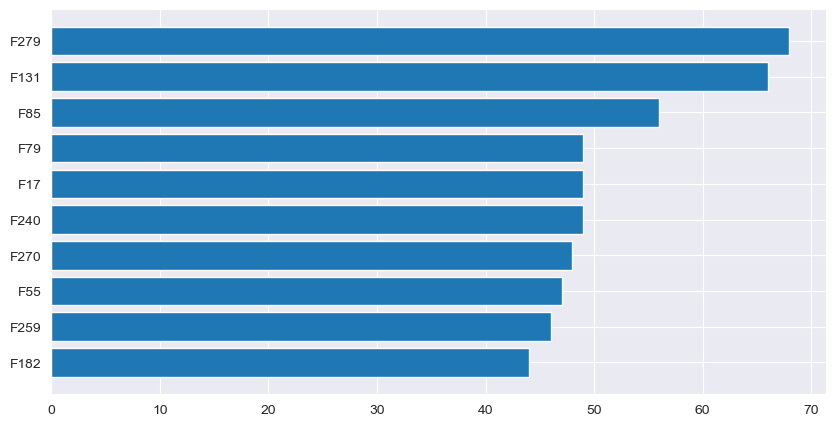

In [11]:
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

class_list = np.unique(y)
class_pairs = list(combinations(class_list, 2))

pairwise_top_10_mean_diff = {}
for cls0, cls1 in class_pairs:
    idx0 = (y == cls0)
    idx1 = (y == cls1)

    # Calculate the feature mean difference between class0 and class1
    mean0 = X[idx0].mean(axis=0)
    mean1 = X[idx1].mean(axis=0)
    diff = np.abs(mean0 - mean1)

    # Sort feature differences, select top 10
    top_10_idx_mean_diff = np.argsort(diff)[::-1][:10]

    feature_info_mean_diff = []
    for rank, feat_idx in enumerate(top_10_idx_mean_diff):
        feature_info_mean_diff.append({
            "feature_idx": int(feat_idx),
            "mean_diff": float(diff[feat_idx]),
            "rank": rank + 1
        })

    pairwise_top_10_mean_diff[(int(cls0), int(cls1))] = feature_info_mean_diff

# Collect all feature idx
all_top_10_features_mean_diff = []
for pair in pairwise_top_10_mean_diff.values():
    all_top_10_features_mean_diff.extend([f['feature_idx'] for f in pair])

# Count frequency
feature_counter_mean_diff = Counter(all_top_10_features_mean_diff)

# Transfer to DataFrame
pairwise_mean_diff_top_10_features_df = pd.DataFrame(feature_counter_mean_diff.items(), columns=["feature_idx", "count"])
pairwise_mean_diff_top_10_features_df.sort_values(by="count", ascending=False, inplace=True)

# Save DataFrame to CSV
pairwise_mean_diff_top_10_features_df.to_csv("../output/pairwise_mean_diff_top_10_features.csv", index=False)

print(f"Top {top_k} most frequently selected features across class pairs:")
print(pairwise_mean_diff_top_10_features_df.head(top_k))

# Visualize
plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in pairwise_mean_diff_top_10_features_df["feature_idx"].head(top_k)][::-1],
    pairwise_mean_diff_top_10_features_df["count"].head(top_k)[::-1]
)

### 1.2 Feature Selection By Max Class Mean Difference

This method is also a coarse-grained analysis by compute max class-wise mean difference for each feature, using the difference between the maximum and minimum means. 

Sort all features in descending order of mean difference.

Top 10 selected features by Max Class Mean Difference:
     feature_idx  mean_diff
131          131   3.301838
85            85   2.968426
112          112   2.851383
182          182   2.824371
125          125   2.796024
181          181   2.776505
71            71   2.728109
297          297   2.721948
75            75   2.692055
259          259   2.660349


<BarContainer object of 10 artists>

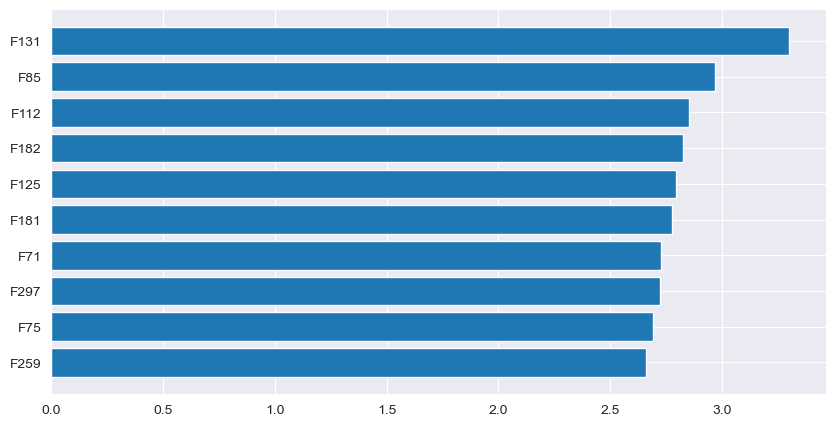

In [16]:
# Store list of max class mean difference
mean_diff_list = []

# Traverse all features
for feature in range(X.shape[1]):
    # Feature mean values in each class
    means = [X[y == label, feature].mean() for label in class_list]

    # Maximum mean difference of the current feature across all classes
    max_diff = np.max(means) - np.min(means)

    mean_diff_list.append((feature, max_diff))
    
# Transfer to DataFrame
max_class_mean_diff_df = pd.DataFrame(mean_diff_list, columns=["feature_idx", "mean_diff"])
max_class_mean_diff_df.sort_values(by="mean_diff", ascending=False, inplace=True)

# Save DataFrame to CSV
max_class_mean_diff_df.to_csv("../output/max_class_mean_diff.csv", index=False)

print(f"Top {top_k} selected features by Max Class Mean Difference:")
print(max_class_mean_diff_df.head(top_k))

# Visualize
plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in max_class_mean_diff_df["feature_idx"].head(top_k)][::-1],
    max_class_mean_diff_df["mean_diff"].head(top_k)[::-1]
)

### 1.3 Pairwise Top 10 Feature Selection By p-value

Top 10 most frequently selected features across class pairs:
    feature_idx  count
43           17     93
13          270     85
90          279     62
55           79     58
39           90     58
36          218     56
45           71     53
5           216     47
62          265     47
10           55     46


<BarContainer object of 10 artists>

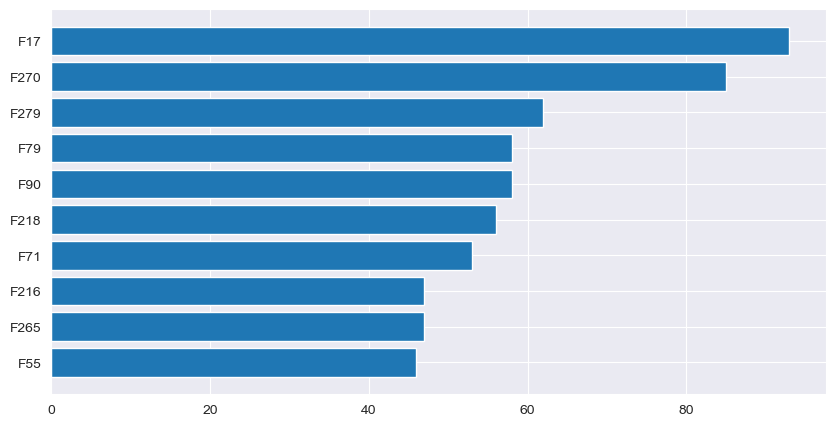

In [19]:
from scipy.stats import ttest_ind

pairwise_top_10_p_value = {}

for cls0, cls1 in class_pairs:
    idx0 = (y == cls0)
    idx1 = (y == cls1)
    
    # t-test for each feature
    p_values =[]
    for feature in range(X.shape[1]):
        stat, p = ttest_ind(X[idx0, feature], X[idx1, feature], equal_var=False)
        p_values.append(p)
        
    # Get first k features from the sorted one 
    p_values = np.array(p_values)
    
    # The smaller the p-value, the more significant the feature is
    top_10_idx_p_value = np.argsort(p_values)[:10]
    
    feature_info_p_value = []
    for rank, feat_idx in enumerate(top_10_idx_p_value):
        feature_info_p_value.append({
            "feature_idx": int(feat_idx),
            "p_value": float(p_values[feat_idx]),
            "rank": rank + 1
        })
        
    pairwise_top_10_p_value[(int(cls0), int(cls1))] = feature_info_p_value
    
# Collect all feature idx
all_top_10_features_p_value = []
for pair in pairwise_top_10_p_value.values():
    all_top_10_features_p_value.extend([f['feature_idx'] for f in pair])

# Count frequency
feature_counter_p_value = Counter(all_top_10_features_p_value)

# Transfer to DataFrame
pairwise_p_value_top_10_features_df = pd.DataFrame(feature_counter_p_value.items(), columns=["feature_idx", "count"])
pairwise_p_value_top_10_features_df.sort_values(by="count", ascending=False, inplace=True)

# Save DataFrame to CSV
pairwise_p_value_top_10_features_df.to_csv("../output/pairwise_p_value_top_10_features.csv", index=False)

print(f"Top {top_k} most frequently selected features across class pairs:")
print(pairwise_p_value_top_10_features_df.head(top_k))

# Visualize
plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in pairwise_p_value_top_10_features_df["feature_idx"].head(top_k)][::-1],
    pairwise_p_value_top_10_features_df["count"].head(top_k)[::-1]
)

### 1.4 Feature Selection By Mutual Information Globally

Top 10 selected features by mutual information globally:
     feature_idx  mi_global_score
48            48         0.318193
270          270         0.304972
17            17         0.301547
263          263         0.275074
90            90         0.269411
172          172         0.266451
231          231         0.258278
283          283         0.251765
88            88         0.250956
71            71         0.238814


<BarContainer object of 10 artists>

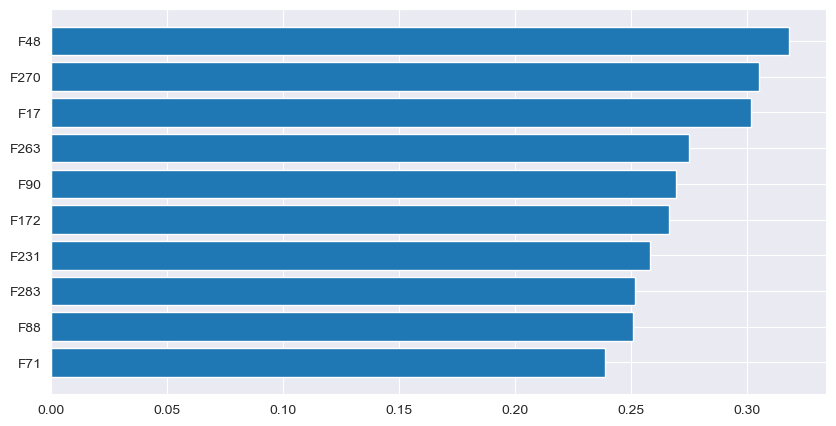

In [22]:
from sklearn.feature_selection import mutual_info_classif

# Calculate all the MI score between feature and label
mi_scores_all_features = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# Construct complete DataFrame of mutual information scores
mutual_info_global_df = pd.DataFrame({"feature_idx": np.arange(len(mi_scores_all_features)),"mi_global_score": mi_scores_all_features})
mutual_info_global_df.sort_values(by="mi_global_score", ascending=False, inplace=True)

# Save DataFrame to CSV
mutual_info_global_df.to_csv("../output/mutual_info_global.csv", index=False)

print(f"Top {top_k} selected features by mutual information globally:")
print(mutual_info_global_df.head(top_k))

# Visualize
plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in mutual_info_global_df["feature_idx"].head(top_k)][::-1],
    mutual_info_global_df["mi_global_score"].head(top_k)[::-1]
)


### 1.5 Feature Selection by ANOVA F-score and P-value

Top 10 selected features by ANOVA F-score and P-value:
     feature_idx     f_score  p_value
48            48  316.406386      0.0
17            17  287.122140      0.0
263          263  276.539340      0.0
270          270  270.317512      0.0
172          172  235.470747      0.0
283          283  231.884127      0.0
231          231  225.079941      0.0
90            90  220.464602      0.0
111          111  217.439776      0.0
88            88  210.569472      0.0


<BarContainer object of 10 artists>

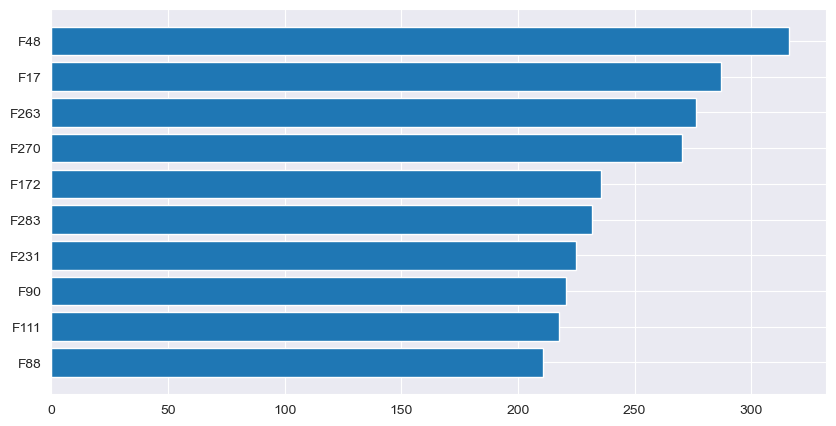

In [25]:
from sklearn.feature_selection import SelectKBest,f_classif

# Feature selection using analysis of variance (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k=X.shape[1])
selector.fit(X,y)

# Extract the F score and corresponding p value of each feature
f_scores = selector.scores_
p_values = selector.pvalues_
feature_idx = selector.get_support(indices=True)

# Construct DataFrame
f_score_with_p_value_df = pd.DataFrame({'feature_idx': feature_idx,'f_score': f_scores[feature_idx],'p_value': p_values[feature_idx]})
f_score_with_p_value_df.sort_values(by='f_score', ascending=False, inplace=True)

# Save DataFrame to CSV
f_score_with_p_value_df.to_csv("../output/f_score_with_p_value.csv", index=False)

print(f"Top {top_k} selected features by ANOVA F-score and P-value:")
print(f_score_with_p_value_df.head(top_k))

# Visualize
plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in f_score_with_p_value_df["feature_idx"].head(top_k)][::-1],  # 从上往下排
    f_score_with_p_value_df["f_score"].head(top_k)[::-1],  
)

## Impact of class imbalance and mitigation methods

E:\Languages\Anaconda3\envs\py310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Anaconda3\envs\p

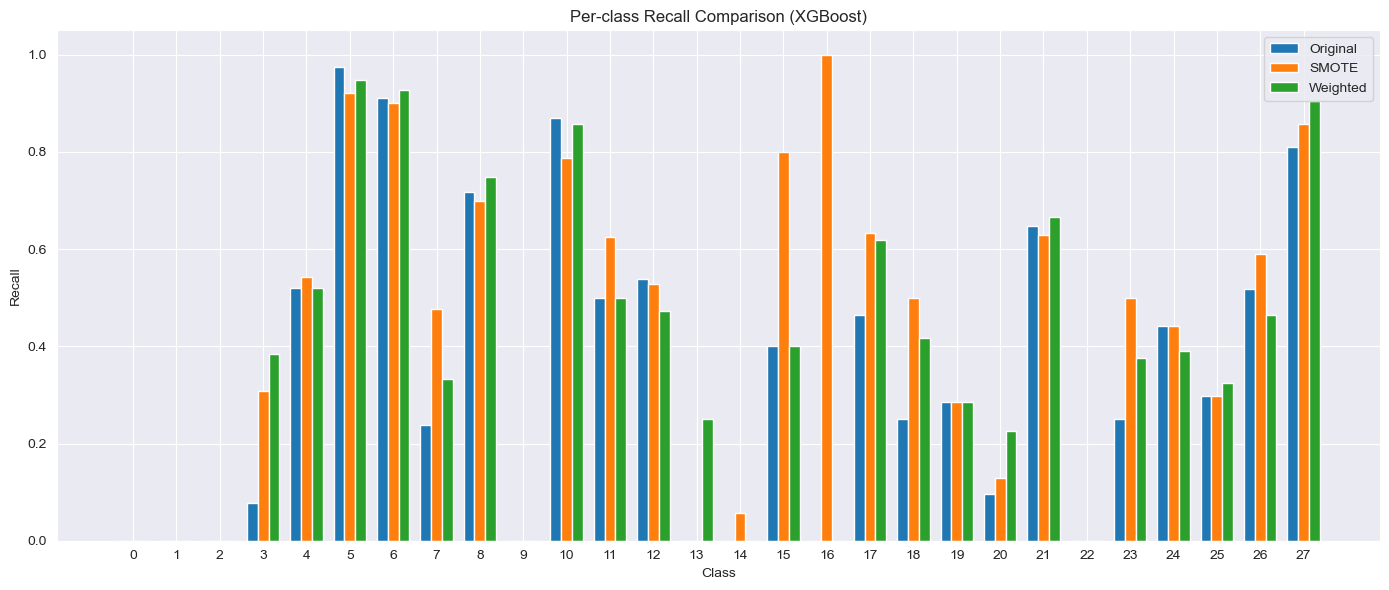

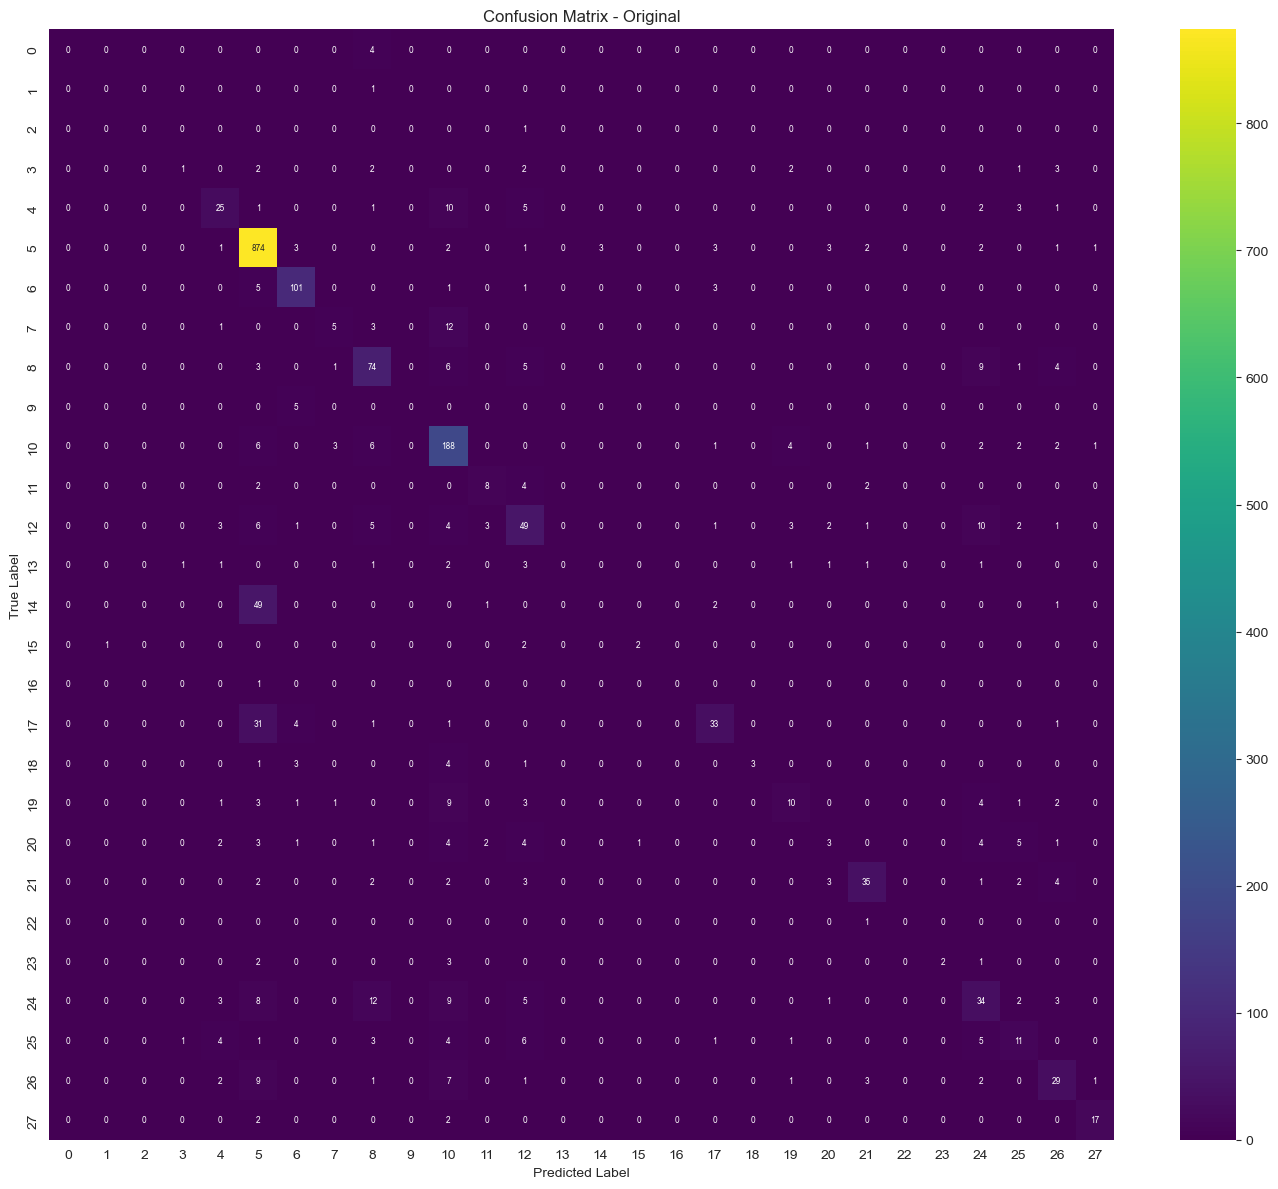

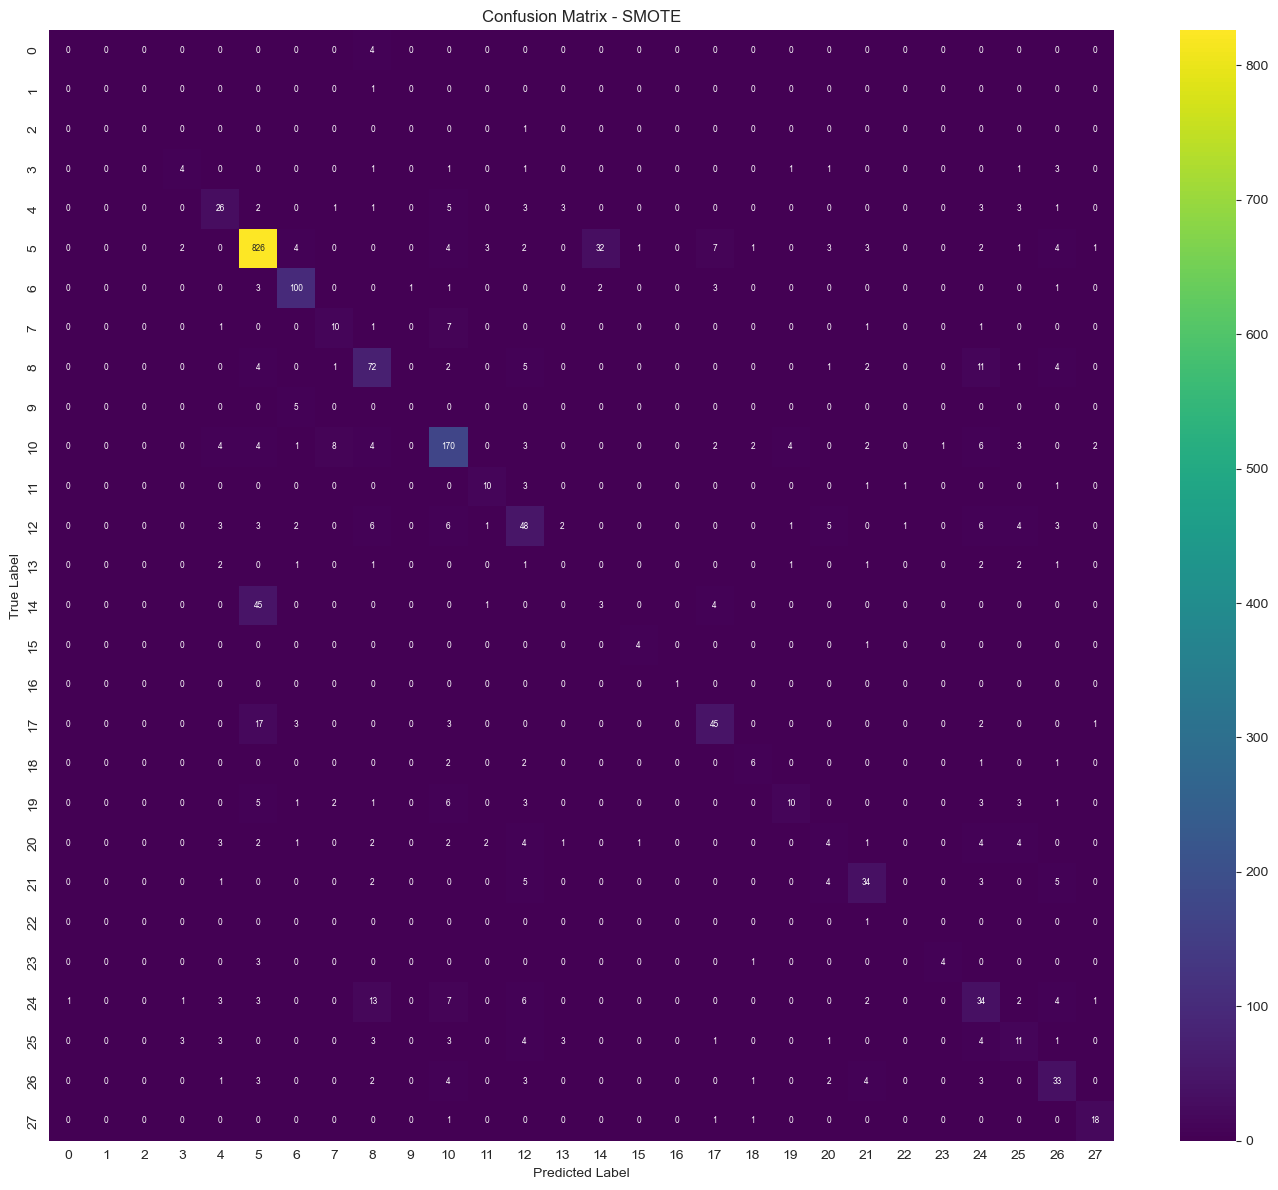

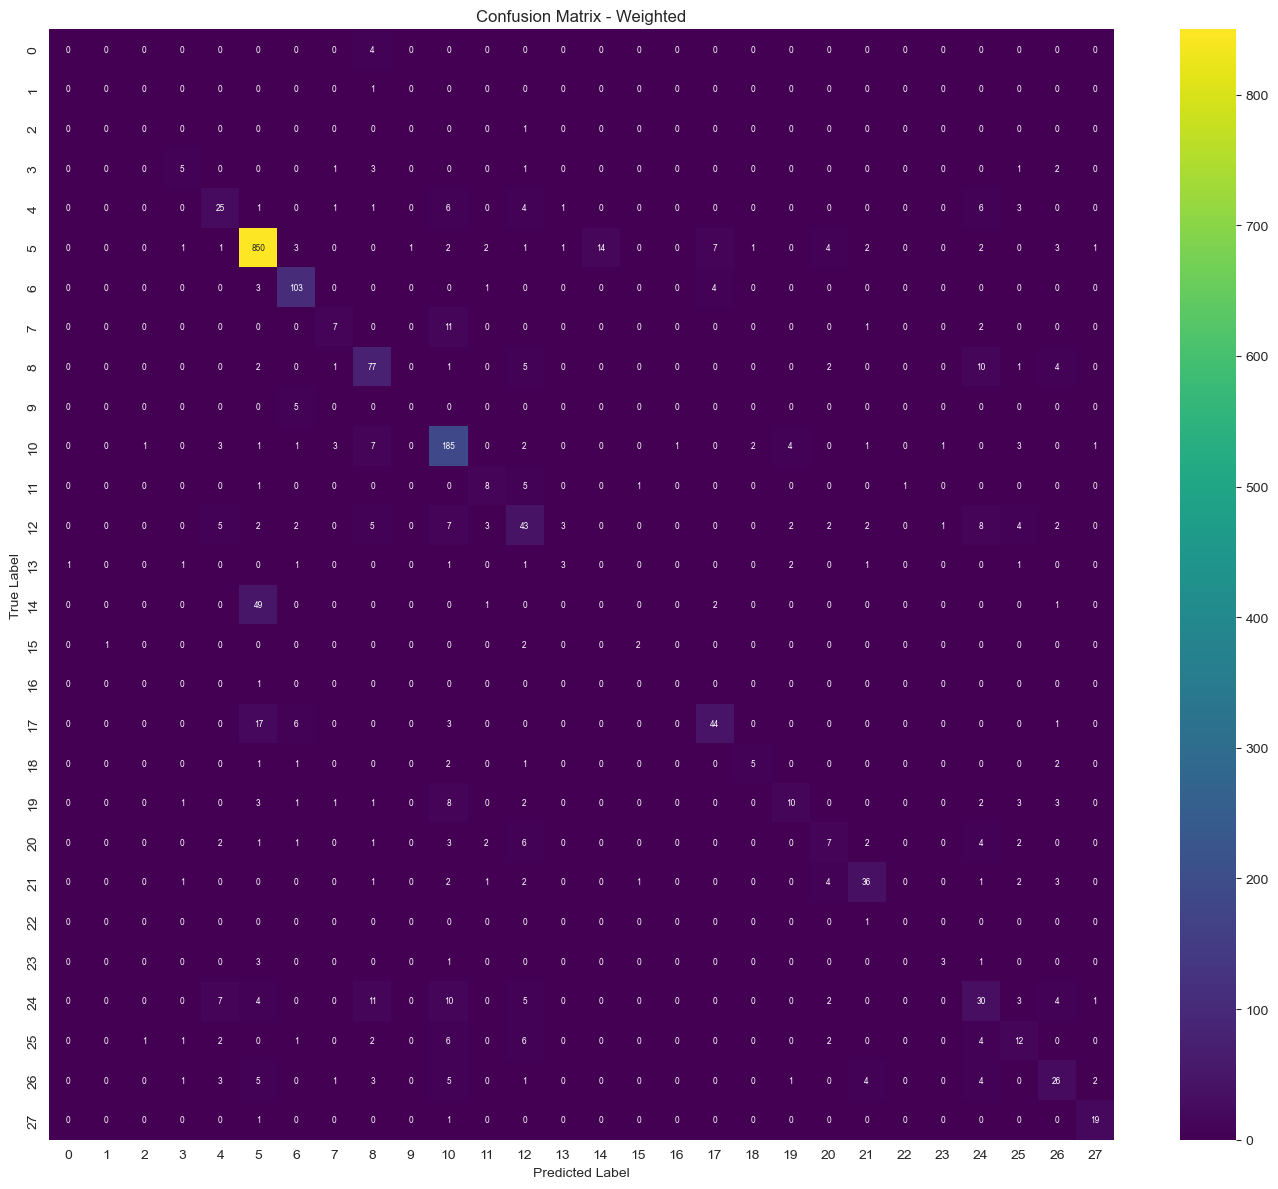

    Class  Original     SMOTE  Weighted
0       0  0.000000  0.000000  0.000000
1       1  0.000000  0.000000  0.000000
2       2  0.000000  0.000000  0.000000
3       3  0.076923  0.307692  0.384615
4       4  0.520833  0.541667  0.520833
5       5  0.975446  0.921875  0.948661
6       6  0.909910  0.900901  0.927928
7       7  0.238095  0.476190  0.333333
8       8  0.718447  0.699029  0.747573
9       9  0.000000  0.000000  0.000000
10     10  0.870370  0.787037  0.856481
11     11  0.500000  0.625000  0.500000
12     12  0.538462  0.527473  0.472527
13     13  0.000000  0.000000  0.250000
14     14  0.000000  0.056604  0.000000
15     15  0.400000  0.800000  0.400000
16     16  0.000000  1.000000  0.000000
17     17  0.464789  0.633803  0.619718
18     18  0.250000  0.500000  0.416667
19     19  0.285714  0.285714  0.285714
20     20  0.096774  0.129032  0.225806
21     21  0.648148  0.629630  0.666667
22     22  0.000000  0.000000  0.000000
23     23  0.250000  0.500000  0.375000


In [26]:
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Step 1: Split into sub-train and validation
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Standardize
scaler = StandardScaler()
X_subtrain_std = scaler.fit_transform(X_subtrain)
X_val_std = scaler.transform(X_val)

# Step 3: Apply SMOTE
min_samples = min(Counter(y_subtrain).values())
k = max(1, min(min_samples - 1, 5))
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=k).fit_resample(X_subtrain_std, y_subtrain)

# Step 4: Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_subtrain), y=y_subtrain)
class_weights = dict(zip(np.unique(y_subtrain), weights))
sample_weights = np.array([class_weights[label] for label in y_subtrain])

# Step 5: Train models

# A. Original
model_a = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_a.fit(X_subtrain_std, y_subtrain)
y_pred_a = model_a.predict(X_val_std)

# B. SMOTE
model_b = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_b.fit(X_smote, y_smote)
y_pred_b = model_b.predict(X_val_std)

# C. Class-weighted
model_c = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_c.fit(X_subtrain_std, y_subtrain, sample_weight=sample_weights)
y_pred_c = model_c.predict(X_val_std)

# Step 6: Compute weighted F1 scores
results_xgb = {
    "A.Original": f1_score(y_val, y_pred_a, average="weighted"),
    "B.SMOTE": f1_score(y_val, y_pred_b, average="weighted"),
    "C.Weighted": f1_score(y_val, y_pred_c, average="weighted"),
}

# Step 7: Per-class recall
recall_df = pd.DataFrame({
    "Class": np.arange(28),
    "Original": recall_score(y_val, y_pred_a, average=None, zero_division=0),
    "SMOTE": recall_score(y_val, y_pred_b, average=None, zero_division=0),
    "Weighted": recall_score(y_val, y_pred_c, average=None, zero_division=0),
})

# Step 8: Confusion matrix plotting
def plot_conf_matrix(title, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize=None, labels=np.arange(28))
    plt.figure(figsize=(14, 12))  
    sns.heatmap(cm, 
                annot=True, 
                fmt=".0f",         
                cmap="viridis", 
                annot_kws={"size": 6}, 
                xticklabels=np.arange(28), 
                yticklabels=np.arange(28))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Step 9: Recall comparison bar chart
plt.figure(figsize=(14, 6))
x = np.arange(len(recall_df))
width = 0.25
plt.bar(x - width, recall_df["Original"], width=width, label="Original")
plt.bar(x, recall_df["SMOTE"], width=width, label="SMOTE")
plt.bar(x + width, recall_df["Weighted"], width=width, label="Weighted")
plt.xticks(ticks=x, labels=recall_df["Class"])
plt.xlabel("Class")
plt.ylabel("Recall")
plt.title("Per-class Recall Comparison (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Confusion matrices
plot_conf_matrix("Confusion Matrix - Original", y_val, y_pred_a)
plot_conf_matrix("Confusion Matrix - SMOTE", y_val, y_pred_b)
plot_conf_matrix("Confusion Matrix - Weighted", y_val, y_pred_c)

# Step 11: Classification reports
report_original = pd.DataFrame(classification_report(y_val, y_pred_a, output_dict=True, zero_division=0)).T
report_smote = pd.DataFrame(classification_report(y_val, y_pred_b, output_dict=True, zero_division=0)).T
report_weighted = pd.DataFrame(classification_report(y_val, y_pred_c, output_dict=True, zero_division=0)).T

print(recall_df)
print(results_xgb)


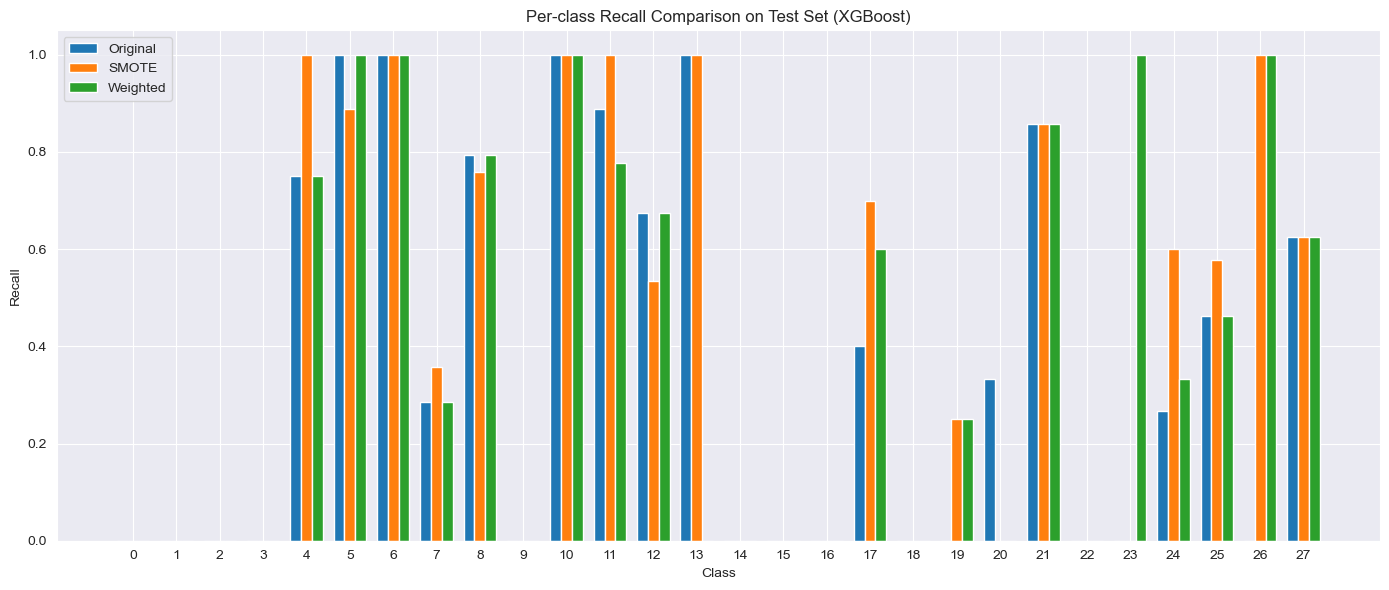

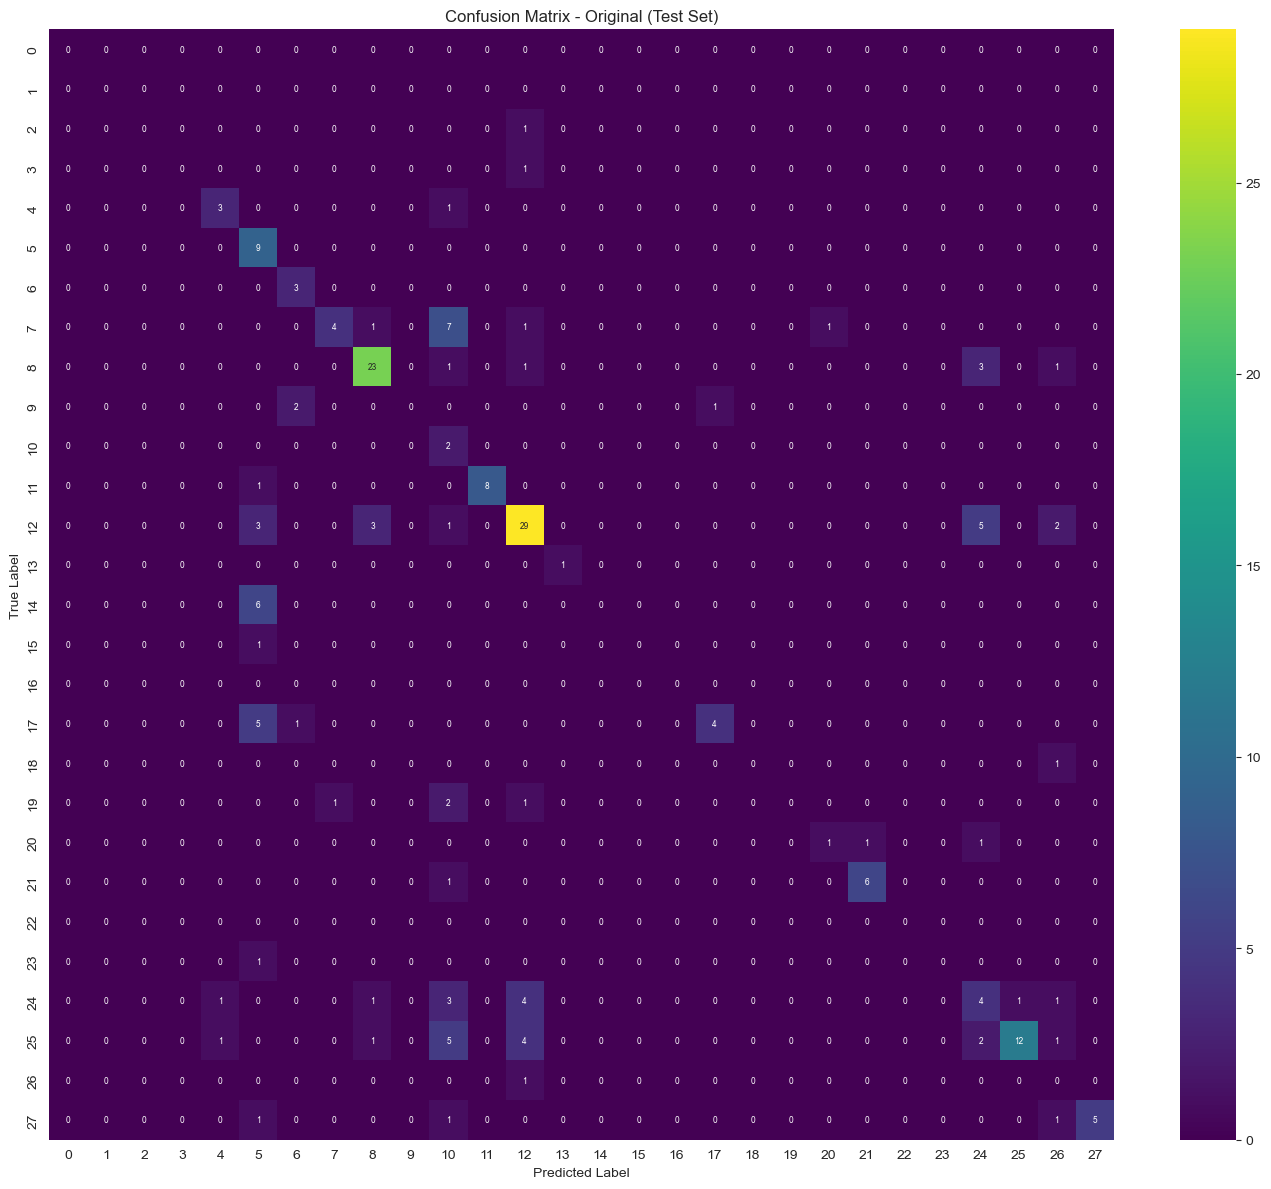

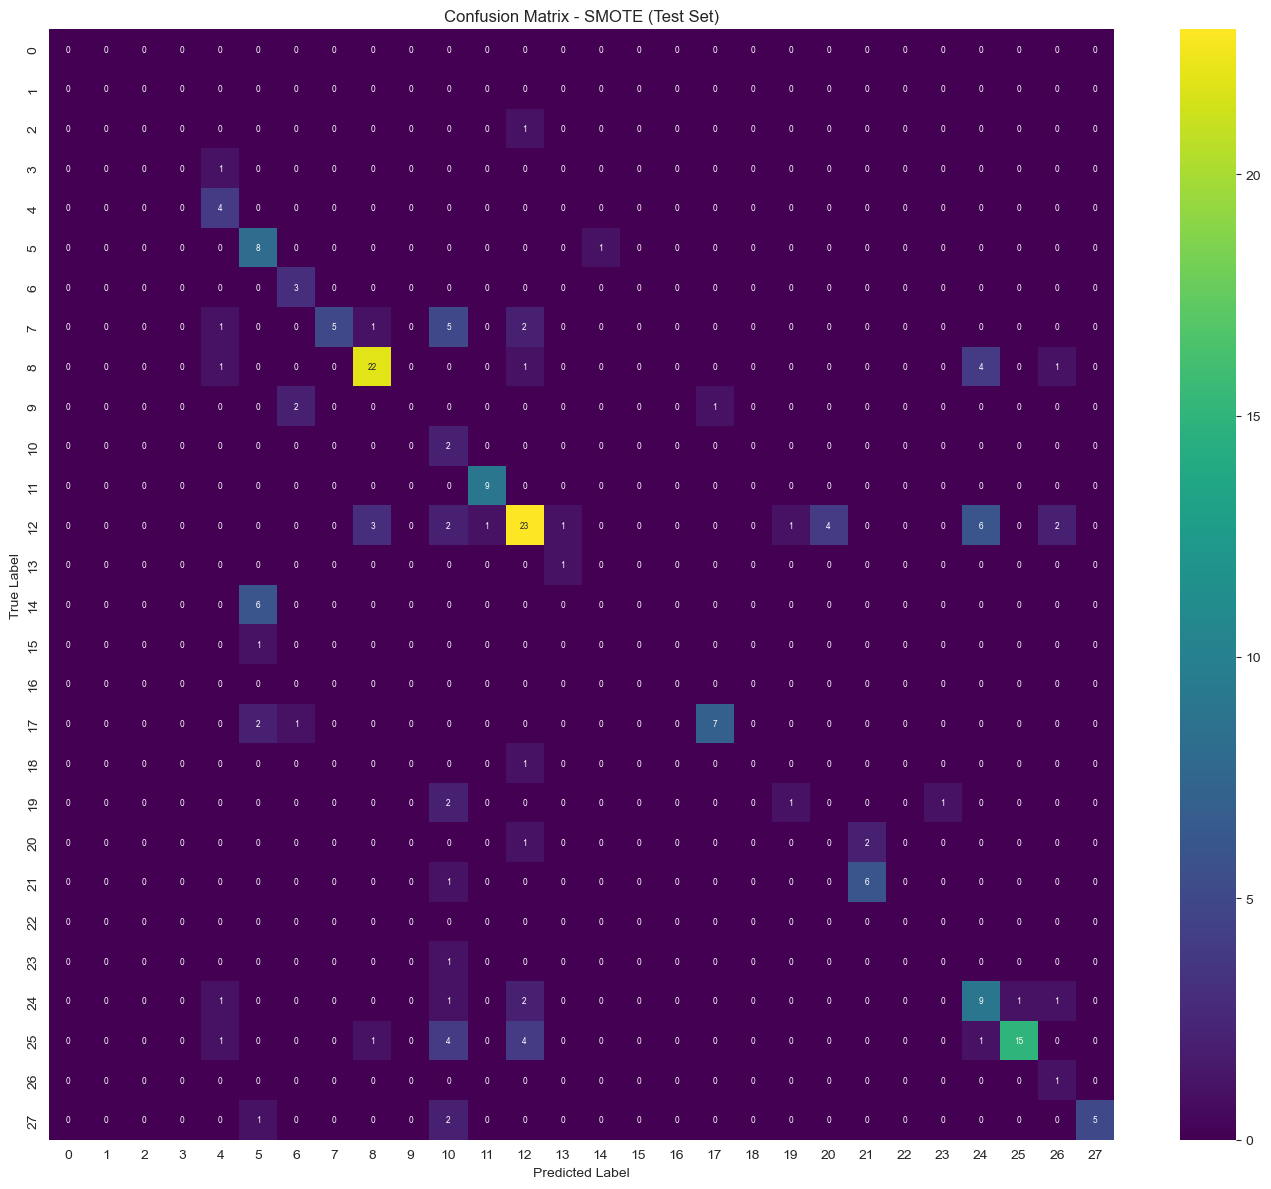

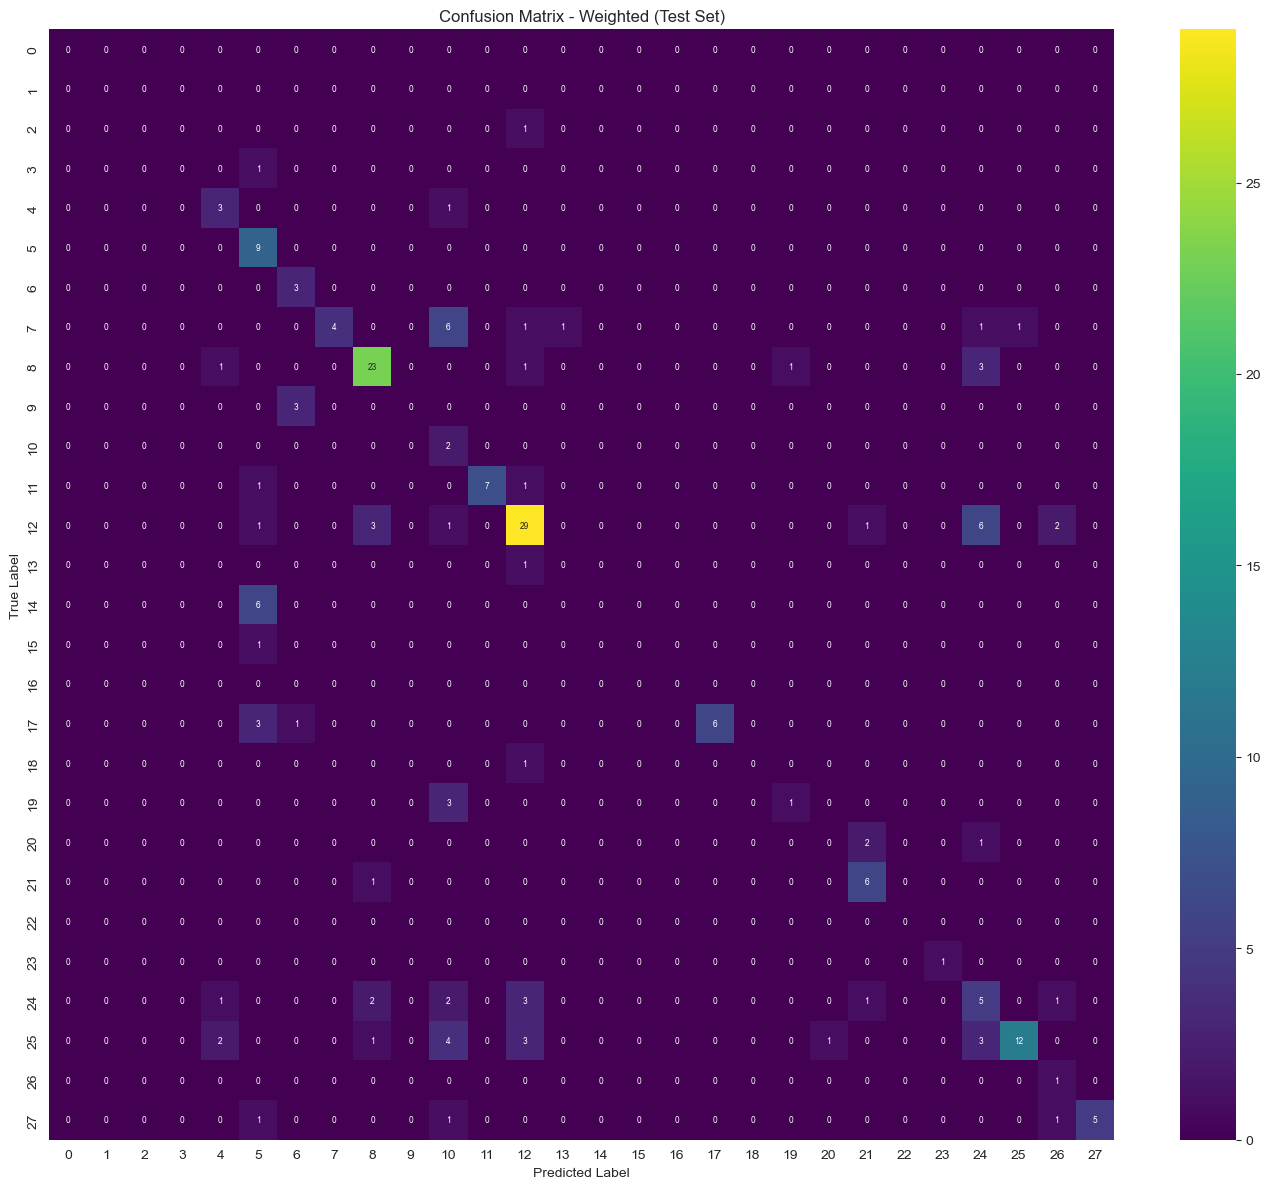

    Class  Original     SMOTE  Weighted
0       0  0.000000  0.000000  0.000000
1       1  0.000000  0.000000  0.000000
2       2  0.000000  0.000000  0.000000
3       3  0.000000  0.000000  0.000000
4       4  0.750000  1.000000  0.750000
5       5  1.000000  0.888889  1.000000
6       6  1.000000  1.000000  1.000000
7       7  0.285714  0.357143  0.285714
8       8  0.793103  0.758621  0.793103
9       9  0.000000  0.000000  0.000000
10     10  1.000000  1.000000  1.000000
11     11  0.888889  1.000000  0.777778
12     12  0.674419  0.534884  0.674419
13     13  1.000000  1.000000  0.000000
14     14  0.000000  0.000000  0.000000
15     15  0.000000  0.000000  0.000000
16     16  0.000000  0.000000  0.000000
17     17  0.400000  0.700000  0.600000
18     18  0.000000  0.000000  0.000000
19     19  0.000000  0.250000  0.250000
20     20  0.333333  0.000000  0.000000
21     21  0.857143  0.857143  0.857143
22     22  0.000000  0.000000  0.000000
23     23  0.000000  0.000000  1.000000


In [31]:
# Step 1: 准备测试集数据
X_test_all = pd.read_csv("../data/X_test_2.csv", skiprows=1, header=None).values[:202]
y_test = pd.read_csv("../data/y_test_2_reduced.csv", skiprows=1, header=None).values.ravel()

# Step 2: 标准化
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X)
X_test_std = scaler.transform(X_test_all)

# Step 3: 模型训练与评估
results = {}

# A. 原始训练
model_a = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_a.fit(X_train_std, y)
y_pred_a = model_a.predict(X_test_std)
results["A.Original"] = f1_score(y_test, y_pred_a, average="weighted")

# B. SMOTE
min_samples = np.min(np.bincount(y))
k = max(1, min(min_samples - 1, 5))
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=k).fit_resample(X_train_std, y)
model_b = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_b.fit(X_smote, y_smote)
y_pred_b = model_b.predict(X_test_std)
results["B.SMOTE"] = f1_score(y_test, y_pred_b, average="weighted")

# C. 类权重
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(zip(np.unique(y), weights))
sample_weights = np.array([class_weights[label] for label in y])
model_c = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_c.fit(X_train_std, y, sample_weight=sample_weights)
y_pred_c = model_c.predict(X_test_std)
results["C.Weighted"] = f1_score(y_test, y_pred_c, average="weighted")

# Step 4: per-class recall
recall_df_test = pd.DataFrame({
    "Class": np.arange(28),
    "Original": recall_score(y_test, y_pred_a, average=None, labels=np.arange(28), zero_division=0),
    "SMOTE": recall_score(y_test, y_pred_b, average=None, labels=np.arange(28), zero_division=0),
    "Weighted": recall_score(y_test, y_pred_c, average=None, labels=np.arange(28), zero_division=0),
})

plt.figure(figsize=(14, 6))
x = np.arange(len(recall_df_test))
width = 0.25
plt.bar(x - width, recall_df_test["Original"], width=width, label="Original")
plt.bar(x, recall_df_test["SMOTE"], width=width, label="SMOTE")
plt.bar(x + width, recall_df_test["Weighted"], width=width, label="Weighted")
plt.xticks(ticks=x, labels=recall_df_test["Class"])
plt.xlabel("Class")
plt.ylabel("Recall")
plt.title("Per-class Recall Comparison on Test Set (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

# Step 5: Confusion Matrices
plot_conf_matrix("Confusion Matrix - Original (Test Set)", y_test, y_pred_a)
plot_conf_matrix("Confusion Matrix - SMOTE (Test Set)", y_test, y_pred_b)
plot_conf_matrix("Confusion Matrix - Weighted (Test Set)", y_test, y_pred_c)

# Step 6: Classification reports
report_original = pd.DataFrame(classification_report(y_test, y_pred_a, output_dict=True, zero_division=0)).T
report_smote = pd.DataFrame(classification_report(y_test, y_pred_b, output_dict=True, zero_division=0)).T
report_weighted = pd.DataFrame(classification_report(y_test, y_pred_c, output_dict=True, zero_division=0)).T

print(recall_df_test)
print(results)


## Why is the accuracy always fails in class imbalance scenario? Is there any more suitable evaluation matrix?

 类别分布严重不平衡的多分类问题中，传统的准确率（Accuracy）指标往往无法真实反映模型性能。例如，当训练数据中某一主类占比达到 95% 时，模型即便始终预测为该主类，也可轻松获得 95% 的准确率。然而，此时模型对其他 27 个类别完全没有学习能力。因此，仅使用准确率作为评估标准，会对模型在少数类上的表现产生误导性判断。

为更全面地评估模型性能，尤其是其对少数类的识别能力，我们将采用以下更优的评价指标：

- **Precision（精确率）**：用于衡量模型在预测为某类时的正确率。它反映了误报（False Positives）情况，特别适合对错误预测代价较高的场景。
  
- **Recall（召回率）**：衡量模型在实际属于某类的样本中被成功识别出来的比例，强调覆盖性。对于少数类识别能力的评估尤为关键。
  
- **F1-score**：精确率与召回率的调和平均值，兼顾“预测准确性”与“检测全面性”，在精确率和召回率存在权衡时能提供更稳定的评价。
  
- **AUC-ROC / AUC-PR 曲线面积**：从概率输出角度评价模型的排序能力。特别是 AUC-PR，在正负样本比例极度失衡时更为敏感，是对少数类预测质量的补充评估手段。
  
- **Confusion Matrix（混淆矩阵）**：直观展示模型在各类别上的预测正确率与混淆情况，有助于发现模型在哪些具体类别上存在识别偏差。

此外，我们将会使用不同的聚合方式：
- `macro` 平均对每个类别赋予相同权重，反映模型在所有类别上的“公平性”；
- `weighted` 平均根据类别样本数加权，更能代表模型整体预测性能。
